## Wu-Yang Method for KS Inversion
Please check the original paper of the Wu-Yang method: [Qin Wu, Weitao Yang, J. Chem. Phys. 118, 2498 (2003)](https://aip.scitation.org/doi/abs/10.1063/1.1535422?casa_token=caPxLNp1Jm8AAAAA:WsOECHVnX79_uiv6Gxx7DcxXcQ2QTl-_wRKNVekhXK9gIvVZ22T2oFk9_hya4Tc8C7iixmki3YceYA).

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True}) # This is currently necessary for inverter to borrow JK from input wfn.
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 


  Memory set to   2.328 GiB by Python driver.


---
### Perform target calculation with Psi4. 
Store wavefunction (wfn) object

In [2]:
Be = psi4.geometry( 
""" 
0 1
Be 
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf"})  # Spin-Restricted

# IMPORTANT NOTE: psi4.energy does not update cc densities. So we calculate dipole moments instead.
wfn = psi4.properties("ccsd/aug-cc-pvtz",  return_wfn=True, molecule=Be, property=['dipole'])[1]

# Build inverter and set target from the wavefunction.
inv = n2v.Inverter.from_wfn(wfn, pbs='aug-cc-pvqz')

---
### Invert! 
$$v_{Kohn-Sham}=v_{ext}+v_{guide}+v_{PBE}$$
With the guide potential $v_{guide}=v_{Fermi-Amaldi}$ and the rest potential $v_{rest}$ on the potential basis set (pbs) "aug-cc-pvqz".

In [3]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
inv.invert("WuYang", guide_components="fermi_amaldi")

Optimization Successful within 2 iterations! |grad|=6.10e-04


---
### Visualization of the potentials. 
#### Since this is a 1-D system, let's first plot it alone x axis.

In [4]:
# Build Grid

x = np.linspace(-5,5,101)
y = np.zeros_like(x)
z = np.zeros_like(x)
grid = np.array([x,y,z])

# Additionaly, one can use the generate grid function. 
grid2 = inv.eng.grid.generate_grid(x=x, y=[0], z=[0])[0]

In [5]:
# Get Hartree and Fermi-Amadli Potentials:

vH = inv.eng.grid.esp(Da=inv.Dt[0], Db=inv.Dt[1], grid=grid)[1]
vFA = (1-1/(inv.nalpha + inv.nbeta)) * vH

---
Fintally, let's find the exchange-correlation potential:
\begin{align}
v_{xc}
&=v_{Kohn-Sham}-v_{Hartree}-v_{ext}\\
&=v_{guide}+v_{rest}-v_{Hartree}
\end{align}

In [6]:
vrest = inv.eng.grid.ao(inv.v_pbs, grid=grid, basis=inv.eng.pbs)  # Note that specify the basis set 
                                                                  # that vrest is on.
    
# Compute vxc according to the previous equation. 
vxc = vFA + vrest - vH

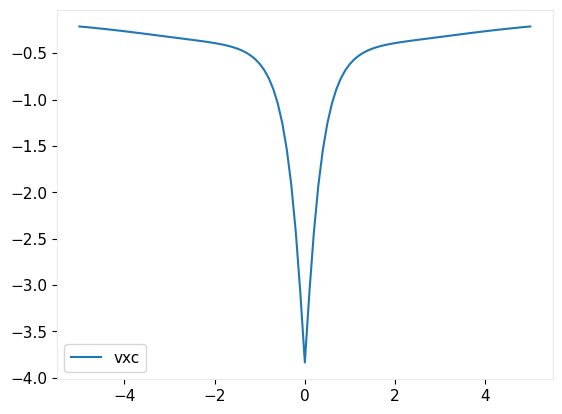

In [7]:
# Plot the potential. 
fig, ax = plt.subplots()
ax.plot(x, vxc, label="vxc")
ax.legend()